This notebook contains a prototype for a workflow that would allow you to compare observations that were sampled in dicrete time to the model output in continuous time. Only the first 14 cells work, and even then they are so unbelievably slow as to be almost entirely useless. 

In [19]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [20]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from erddapy import ERDDAP
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
import Keegan_eval_tools as ket
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [21]:
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [22]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData/WADE_nutribot_pickles'

with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [23]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]

In [33]:
%%time
start= dt.datetime(2010,1,1)
end=dt.datetime(2010,12,31) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file


CPU times: user 18.7 ms, sys: 16.4 ms, total: 35.1 ms
Wall time: 797 ms


In [34]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['S3']['NEMO grid ji']
ik=2 # choose surface level

In [35]:
ii=data[data.Station == 'BUD005'].i.unique()[0]
ij=data[data.Station == 'BUD005'].j.unique()[0]
ik=2

In [36]:
bio=xr.open_mfdataset(flist['paths'])

In [37]:
%%time
tt=bio.time_counter
NO23=bio.nitrate.isel(deptht=ik,y=ij,x=ii) #.cell will give closest to two meters 
#this is where we have the depth problem. 

CPU times: user 2.43 ms, sys: 327 µs, total: 2.76 ms
Wall time: 2.76 ms


In [38]:
def TsByStation_ind2 (df,datstat,regions,obsvar,modvar,year,ylim,figsize=(14,40),loc='lower left',depth=5):  
    stations=[]
    for r in regions:
        sta0=df[df['Basin']==r].Station.unique()
        stations.append(sta0)
    stations = [val for sublist in stations for val in sublist]
    fig,ax=plt.subplots(math.ceil(len(stations)/2),2,figsize=figsize)
    new_stat = [stations[i:i+2] for i in range(0, len(stations), 2)]
    for si,axi in zip(new_stat,ax):
        for sj,axj in zip(si,axi):
            #The creation of the observed data points
            ps=[]
            obs0=et._deframe(df.loc[(df['dtUTC'] >= dt.datetime(year,1,1))&(df['dtUTC']<= dt.datetime(year,12,31))&(df['Station']==sj)&(df['Z']<=depth),[obsvar]])
            time0=et._deframe(df.loc[(df['dtUTC'] >= dt.datetime(year,1,1))&(df['dtUTC']<= dt.datetime(year,12,31))&(df['Station']==sj)&(df['Z']<=depth),['dtUTC']])
            p0,=axj.plot(time0,obs0,'.',color='blue',label=f'Observed {obsvar}',marker='o',fillstyle='none')
            ps.append(p0)
            # The creation of the model data line 
            ii=data[data.Station == sj].i.unique()[0]
            ij=data[data.Station == sj].j.unique()[0]
            ik=0
            tt=bio.time_counter
            NO23=bio[modvar].isel(deptht=ik,y=ij,x=ii)
            p0,=axj.plot(tt,NO23,'-',color='darkorange',label='Nitrate')
            ps.append(p0)
            #labeling and formatting
            axj.set_ylabel('Concentration ($\mu$M)')
            axj.set_xlim(tt[0],tt[-1])
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=13)
            axj.set_title(f'{df[df.Station==sj].Basin.unique()[0]} ({sj})', fontsize=13)
            axj.set_ylim(ylim)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

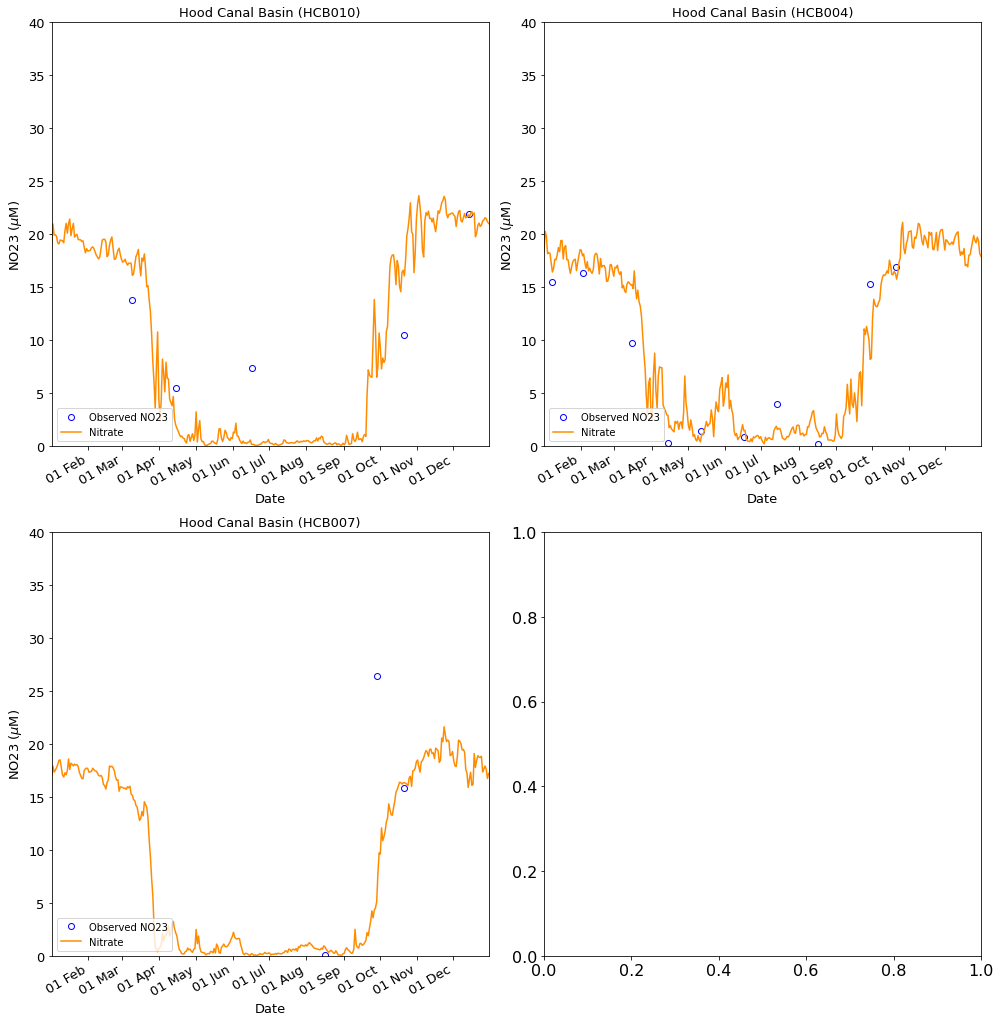

In [39]:
obsvar='NO23'
modvar='nitrate'
regions=['Hood Canal Basin']
lims=(0,40)

TsByStation_ind2(data,datstat,regions,obsvar,modvar,year,lims,figsize=(14,14),loc='lower left')

In [40]:
bio.close()

Hmmm The fact that there are multiple different points at different depths make this technique mostly useless. Even if I fix it so that there are multiple lines or something, it will take so long it will be almost useless. Perhaps If I only look at observations at a certain depth it can be at least a little helpful. 

In [15]:
# Now we are actually loading everything from a website/ online database instead of from our own results storage.
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "griddap"

dataset_id = "ubcSSg3DBiologyFields1hV19-05"

response = "nc"

variables = [
    "nitrate",
    "time",
]

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
}

print(constraints)

{'time>=': '2015-02-01T00:00:00Z', 'time<=': '2015-04-01T00:00:00Z'}


In [16]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [17]:
obs
print(obs.get_download_url())

https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV19-05.html?nitrate,time&time>=1422748800.0&time<=1427846400.0


In [18]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()
obs_pd

HTTPError: <!DOCTYPE html><html><head><title>Apache Tomcat/8.0.28 - Error report</title><style type="text/css">H1 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:22px;} H2 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:16px;} H3 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:14px;} BODY {font-family:Tahoma,Arial,sans-serif;color:black;background-color:white;} B {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;} P {font-family:Tahoma,Arial,sans-serif;background:white;color:black;font-size:12px;}A {color : black;}A.name {color : black;}.line {height: 1px; background-color: #525D76; border: none;}</style> </head><body><h1>HTTP Status 500 - Query error: In a griddap query, '&amp;' must be followed by a .graphicsCommand.</h1><div class="line"></div><p><b>type</b> Status report</p><p><b>message</b> <u>Query error: In a griddap query, '&amp;' must be followed by a .graphicsCommand.</u></p><p><b>description</b> <u>The server encountered an internal error that prevented it from fulfilling this request.</u></p><hr class="line"><h3>Apache Tomcat/8.0.28</h3></body></html>

In [ ]:
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "tabledap"

dataset_id = "ubcONCTWDP1mV18-01"

response = "nc"

variables = [
    "latitude",
    "longitude",
    "chlorophyll",
    "time",
]

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

print(constraints)

In [ ]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [ ]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

In [ ]:
obs_pd